## COPERNICUS Vegetation Indicatorss 

### <a name="service">Service Definition

In [1]:
service = dict([('title', 'COPERNICUS Vegetation Indicators - Aggregations'),
                ('abstract', 'COPERNICUS Vegetation Indicators - Aggregations'),
                ('id', 'wfp-01-03-01')])

### <a name="parameter">Parameter Definition 

In [2]:
N_1 = dict([('id', 'N_1'),
                          ('value', 'False'),
                          ('title', 'No Aggregation'),
                          ('abstract', 'No aggregation')])

In [3]:
N_3 = dict([('id', 'N_3'),
                          ('value', 'True'),
                          ('title', '30 Day Aggregation'),
                          ('abstract', 'Get a 30 day aggregation')])

In [4]:
N_6 = dict([('id', 'N_6'),
                          ('value', 'False'),
                          ('title', '60 Day Aggregation'),
                          ('abstract', 'Get a 60 day aggregation')])

In [5]:
N_9 = dict([('id', 'N_9'),
                          ('value', 'False'),
                          ('title', '90 Day Aggregation'),
                          ('abstract', 'Get a 90 day aggregation')])

In [6]:
N_12 = dict([('id', 'N_12'),
                          ('value', 'False'),
                          ('title', '120 Day Aggregation'),
                          ('abstract', 'Get a 120 day aggregation')])

In [7]:
N_15 = dict([('id', 'N_15'),
                          ('value', 'False'),
                          ('title', '150 Day Aggregation'),
                          ('abstract', 'Get a 150 day aggregation')])

In [8]:
N_18 = dict([('id', 'N_18'),
                          ('value', 'False'),
                          ('title', '180 Day Aggregation'),
                          ('abstract', 'Get a 180 day aggregation')])

In [9]:
N_27 = dict([('id', 'N_27'),
                          ('value', 'False'),
                          ('title', '270 Day Aggregation'),
                          ('abstract', 'Get a 270 day aggregation')])

In [10]:
N_36 = dict([('id', 'N_36'),
                          ('value', 'False'),
                          ('title', '360 Day Aggregation'),
                          ('abstract', 'Get a 360 day aggregation')])

In [11]:
regionOfInterest = dict([('id', 'regionOfInterest'),
                          ('value', 'POLYGON((-30 -10, 20 -10, 20 40, -30 40, -30 -10))'),
                          ('title', 'WKT Polygon for the Region of Interest'),
                          ('abstract', 'Set the value of WKT Polygon')])

In [12]:
nameOfRegion = dict([('id', 'nameOfRegion'),
                     ('value', ''),
                     ('title', 'Name of Region'),
                     ('abstract', 'Name of the region of interest'),
                     ('minOccurs', '1')])

### <a name="runtime">Runtime parameter definition

**Input references**

In [13]:
input_references = 'fapar_v2_1km_FAPAR-RT6_201701310000_GLOBE_PROBAV_V2.0.2'

### <a name="workflow">Workflow

#### Import the packages required for processing the data

In [14]:
import os
import sys
#sys.path.append('/opt/OTB-6.2.0/lib/python')
#sys.path.append('/opt/OTB-6.2.0/lib/libfftw3.so.3')
#os.environ['OTB_APPLICATION_PATH'] = '/opt/OTB-6.2.0/lib/otb/applications'
#os.environ['LD_LIBRARY_PATH'] = '/opt/OTB-6.2.0/lib'
#os.environ['ITK_AUTOLOAD_PATH'] = '/opt/OTB-6.2.0/lib/otb/applications'
#os.environ['GDAL_DATA'] = '/opt/anaconda/share/gdal/'
#import otbApplication
from osgeo import gdal
import numpy as np
import pandas as pd
from geopandas import GeoDataFrame
import math
import re
import cioppy
import shutil
sys.path.append('/workspace/wfp-01-03-01/src/main/app-resources/notebook/libexec')
sys.path.append('/application/notebook/libexec')
from aux_functions import calc_average, calc_max_matrix, matrix_sum, crop_image, write_output_image

In [15]:
def get_info(row, search_params):
    search = ciop.search(end_point=row['catalogue_url'], 
                                  params=search_params,
                                  output_fields='identifier,startdate,enclosure',
                                  model='GeoTime')[0]
    
    series = pd.Series(search)
    
    series['startdate'] = pd.to_datetime(series['startdate'])
    
    return series

In [16]:
#input references used for test only. Remove before deploying to sandbox/production.
'''input_references = ['https://catalog.terradue.com/cgls/search?format=atom&uid=fapar_v2_1km_FAPAR-RT6_201802280000_GLOBE_PROBAV_V2.0.1',
                   'https://catalog.terradue.com/cgls/search?format=atom&uid=fapar_v2_1km_FAPAR-RT6_201802200000_GLOBE_PROBAV_V2.0.1',
                   'https://catalog.terradue.com/cgls/search?format=atom&uid=fapar_v2_1km_FAPAR-RT6_201802100000_GLOBE_PROBAV_V2.0.1',
                   'https://catalog.terradue.com/cgls/search?format=atom&uid=fapar_v2_1km_FAPAR-RT6_201801310000_GLOBE_PROBAV_V2.0.1',
                   'https://catalog.terradue.com/cgls/search?format=atom&uid=fapar_v2_1km_FAPAR-RT6_201801200000_GLOBE_PROBAV_V2.0.1',
                   'https://catalog.terradue.com/cgls/search?format=atom&uid=fapar_v2_1km_FAPAR-RT6_201801100000_GLOBE_PROBAV_V2.0.1']
'''
if isinstance(input_references, str):
    input_references = [input_references]

# nameOfRegion['value'] = 'Africa' #placeholder for tests only. Remove before deploying.

nameOfRegion = nameOfRegion['value']

ciop = cioppy.Cioppy()
gpd_data = GeoDataFrame(input_references,
                       columns=['catalogue_url'])
gpd_data.head()
gpd_data = gpd_data.sort_values(by='catalogue_url')
start_date = re.findall('\d{8}0000', gpd_data.iloc[0]['catalogue_url'])[0].replace('0000', '')
end_date = re.findall('\d{8}0000', gpd_data.iloc[-1]['catalogue_url'])[0].replace('0000', '')
start_date = re.sub(r'(\d{4})(\d{2})(\d{2})', r'\1-\2-\3', start_date)
end_date = re.sub(r'(\d{4})(\d{2})(\d{2})', r'\1-\2-\3', end_date)
print(start_date)
print(end_date)
print(len(input_references))
search_params =  dict([('start', start_date),
                      ('stop', end_date),
                      ('count', len(input_references))])

gpd_final = gpd_data.apply(lambda row: get_info(row, search_params), axis=1)
gpd_final.head()

2018-01-10
2018-02-28
6


,enclosure,identifier,startdate
5,https://store.terradue.com/cgls/fapar_v2_1km/2...,fapar_v2_1km_FAPAR-RT6_201801100000_GLOBE_PROB...,2018-01-10
4,https://store.terradue.com/cgls/fapar_v2_1km/2...,fapar_v2_1km_FAPAR-RT6_201801200000_GLOBE_PROB...,2018-01-20
3,https://store.terradue.com/cgls/fapar_v2_1km/2...,fapar_v2_1km_FAPAR-RT6_201801310000_GLOBE_PROB...,2018-01-31
2,https://store.terradue.com/cgls/fapar_v2_1km/2...,fapar_v2_1km_FAPAR-RT6_201802100000_GLOBE_PROB...,2018-02-10
1,https://store.terradue.com/cgls/fapar_v2_1km/2...,fapar_v2_1km_FAPAR-RT6_201802200000_GLOBE_PROB...,2018-02-20


In [17]:
def calc_aggregations(product_list, N_value, region_of_interest, product_type):
    mask_no_data_value = 0
    max_values = 0
    averages = 0
    temp_list = []
    no_data_value = None
    print(type(product_list))
    for product_url in product_list:
        # uncompressed data
        product = (product_url.split('/')[-1]).split('.gz')[0]
        print(product)
        cropped_product_path = 'crop_' + product
        cropped_product_path = cropped_product_path.split('.nc')[0] + '.tif'
        try:
            crop_image(product_url, region_of_interest, cropped_product_path, product_type)
            # Read GeoTIFF as an array
            dataset = gdal.Open(cropped_product_path)
            product_array = dataset.GetRasterBand(1).ReadAsArray()
            no_data_value = dataset.GetRasterBand(1).GetNoDataValue()
            print(no_data_value)
            geo_transform = dataset.GetGeoTransform()
            projection = dataset.GetProjection()
            ## Create mask of no_data_values
            if no_data_value is not None:
                if isinstance(mask_no_data_value, int):
                    mask_no_data_value = np.where(product_array == no_data_value, 1, 0)
                else:
                    temp_mask = np.where(product_array == no_data_value, 1, 0)
                    mask_no_data_value = matrix_sum(mask_no_data_value, temp_mask)
            max_values = calc_max_matrix(max_values, product_array, no_data_value)
            temp_list.append(product_array)
            dataset = None
            
        except Exception as e:
            print('Error processing the product ' + product + ': ' + str(e))
        if os.path.exists(cropped_product_path):
            os.remove(cropped_product_path)
    
    averages = calc_average(temp_list, N_value, no_data_value)
    
    return max_values, averages, mask_no_data_value, geo_transform, projection

In [18]:
def product_stage_in(enclosure, target_dir):
    if not os.path.isdir(target_dir):
        os.mkdir(target_dir)
    return ciop.copy(urls=enclosure, target=target_dir)

In [19]:
def write_outputs(product_name, roi_name, first_date, last_date, averages, max_values, mask_no_data_value, image_format, product_count, projection, geo_transform, no_data_value):
    filenames = []
    filenames.append(product_name + '.' + roi_name + '.' + str(product_count) + '.averages.' + first_date + '.' + last_date + '.tif')
    filenames.append(product_name + '.' + roi_name + '.' + str(product_count) + '.max_values.' + first_date + '.' + last_date + '.tif')
    write_output_image(filenames[0], averages, image_format,  mask_no_data_value, projection, geo_transform, no_data_value)
    write_output_image(filenames[1], max_values, image_format, mask_no_data_value, projection, geo_transform, no_data_value)
    return filenames

In [20]:
def write_properties_file(output_name):
    
    first_date = re.findall('\d{4}\.\d{2}\.\d{2}', output_name)[0]
    last_date = re.findall('\d{4}\.\d{2}\.\d{2}', output_name)[1]
    with open(output_name + '.properties', 'wb') as file:
        file.write('title=%s\n' % output_name)
        file.write('date=%s/%s\n' % (first_date, last_date))
        file.write('geometry=%s' % (regionOfInterest['value']))

In [21]:
nlist = [N_1['value'], N_3['value'], N_6['value'], N_9['value'], N_12['value'], N_15['value'], N_18['value'], N_27['value'], N_36['value']]
region_of_interest = regionOfInterest['value']
nvalue = [1, 3, 6, 9, 12, 15, 18, 27, 36]
L = len(gpd_final.index.values)
nlist = [n=='True' for n in nlist]
print(nlist)
product_years = gpd_final['startdate'].dt.year.unique()
for _year in product_years:
    products_data = gpd_final[(gpd_final['startdate'].dt.year == _year)]
    lai_products = products_data[(products_data['identifier'].str.contains('lai'))]
    fapar_products = products_data[(products_data['identifier'].str.contains('fapar'))]
    if not lai_products.empty:
        products_data = lai_products
        L = len(products_data.index.values)
        months_of_products = products_data['startdate'].dt.month.unique()
        for n in [index for index, value in enumerate(nlist) if value==True]:
            N = nvalue[n]
            n_months = N/3
            n_intervals = int(math.ceil((L*1.00)/N))
            for i in range(n_intervals):
                start_date = products_data[((products_data['startdate'].dt.month == months_of_products[i]))]['startdate'].tolist()[0]
                end_date = products_data[((products_data['startdate'].dt.month == months_of_products[i]+ n_months-1))]['startdate'].tolist()[-1]
                print(start_date)
                print(end_date)
                interval_products = products_data[(products_data['startdate'] >= start_date) & (products_data['startdate'] <= end_date)]['enclosure'].tolist()
                file_list = []
                for enclosure in interval_products:
                    filepath = product_stage_in(enclosure, 'lai_data')
                    file_list.append(filepath)
                print(file_list)
                first_date = start_date.strftime('%Y.%m.%d')
                last_date = end_date.strftime('%Y.%m.%d')
                max_values, averages, no_value, geo_transform, projection = calc_aggregations(file_list, N, region_of_interest, 'LAI')
                filenames = write_outputs('LAI', nameOfRegion, first_date, last_date, averages, max_values, no_value, 'GTiff', N, projection, geo_transform, -999.0)
                for output_name in filenames:
                    write_properties_file(output_name)
                for tmp_file in file_list:
                    os.remove(tmp_file)
    
    if not fapar_products.empty:
        products_data = fapar_products
        L = len(products_data.index.values)
        months_of_products = products_data['startdate'].dt.month.unique()
        for n in [index for index, value in enumerate(nlist) if value==True]:
            N = nvalue[n]
            n_months = N/3
            n_intervals = int(math.ceil((L*1.00)/N))
            for i in range(n_intervals):
                start_date = products_data[((products_data['startdate'].dt.month == months_of_products[i]))]['startdate'].tolist()[0]
                end_date = products_data[((products_data['startdate'].dt.month == months_of_products[i]+ n_months-1))]['startdate'].tolist()[-1]
                print(start_date)
                print(end_date)
                interval_products = products_data[(products_data['startdate'] >= start_date) & (products_data['startdate'] <= end_date)]['enclosure'].tolist()
                file_list = []
                for enclosure in interval_products:
                    filepath = product_stage_in(enclosure, 'fapar_data')
                    file_list.append(filepath)
                print(file_list)
                first_date = start_date.strftime('%Y.%m.%d')
                last_date = end_date.strftime('%Y.%m.%d')
                max_values, averages, no_value, geo_transform, projection = calc_aggregations(file_list, N, region_of_interest, 'FAPAR')            
                filenames = write_outputs('FAPAR', nameOfRegion, first_date, last_date, averages, max_values, no_value, 'GTiff', N, projection, geo_transform, -999.0)
                for output_name in filenames:
                    write_properties_file(output_name)
                for tmp_file in file_list:
                    os.remove(tmp_file)

[False, True, False, False, False, False, False, False, False]
2018-01-10 00:00:00
2018-01-31 00:00:00
['/workspace/wfp-01-03-01/src/main/app-resources/notebook/libexec/fapar_data/c_gls_FAPAR-RT6_201801100000_GLOBE_PROBAV_V2.0.1.nc', '/workspace/wfp-01-03-01/src/main/app-resources/notebook/libexec/fapar_data/c_gls_FAPAR-RT6_201801200000_GLOBE_PROBAV_V2.0.1.nc', '/workspace/wfp-01-03-01/src/main/app-resources/notebook/libexec/fapar_data/c_gls_FAPAR-RT6_201801310000_GLOBE_PROBAV_V2.0.1.nc']
<type 'list'>
c_gls_FAPAR-RT6_201801100000_GLOBE_PROBAV_V2.0.1.nc
255.0
c_gls_FAPAR-RT6_201801200000_GLOBE_PROBAV_V2.0.1.nc
255.0
c_gls_FAPAR-RT6_201801310000_GLOBE_PROBAV_V2.0.1.nc
255.0
2018-02-10 00:00:00
2018-02-28 00:00:00
['/workspace/wfp-01-03-01/src/main/app-resources/notebook/libexec/fapar_data/c_gls_FAPAR-RT6_201802100000_GLOBE_PROBAV_V2.0.1.nc', '/workspace/wfp-01-03-01/src/main/app-resources/notebook/libexec/fapar_data/c_gls_FAPAR-RT6_201802200000_GLOBE_PROBAV_V2.0.1.nc', '/workspace/wfp-0

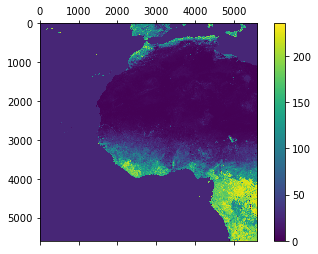

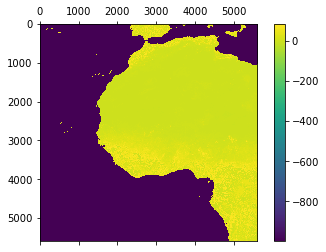

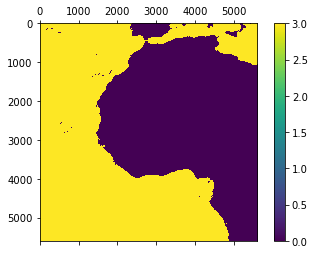

In [22]:
'''from matplotlib import pyplot
%matplotlib inline


fig0 = pyplot.figure()
ax0 = fig0.add_subplot(111)
cax0 = ax0.matshow(max_values)
fig0.colorbar(cax0)

fig1 = pyplot.figure()
ax1 = fig1.add_subplot(111)
cax1 = ax1.matshow(averages)
fig1.colorbar(cax1)


fig = pyplot.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(no_value)
fig.colorbar(cax)

pyplot.show()
'''

### <a name="license">License

This work is licenced under a [Attribution-ShareAlike 4.0 International License (CC BY-SA 4.0)](http://creativecommons.org/licenses/by-sa/4.0/) 

YOU ARE FREE TO:

* Share - copy and redistribute the material in any medium or format.
* Adapt - remix, transform, and built upon the material for any purpose, even commercially.

UNDER THE FOLLOWING TERMS:

* Attribution - You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
* ShareAlike - If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original.